In [4]:
import cv2
import torch
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
import gzip
from utils import *
from dataset import BTCV2DSliceDataset, to_uint8_rgb
from torch.utils.data import DataLoader
from prompt_gen import *
import nibabel as nib
import json

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [6]:
sam = sam_model_registry['default']('./sam_vit_h_4b8939.pth')
sam.to(device)
predictor = SamPredictor(sam)

# Test SAM on single image

In [7]:
image = cv2.imread('./images/Dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
image.shape

(1365, 2048, 3)

In [9]:
predictor.set_image(image)

In [10]:
input_point = np.array([[1200, 800], [1000,700]])
input_label = np.array([1, 1])

In [11]:
masks, scores, logits = predictor.predict(
    point_coords=input_point, 
    point_labels=input_label,
    multimask_output=True,
)

In [12]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

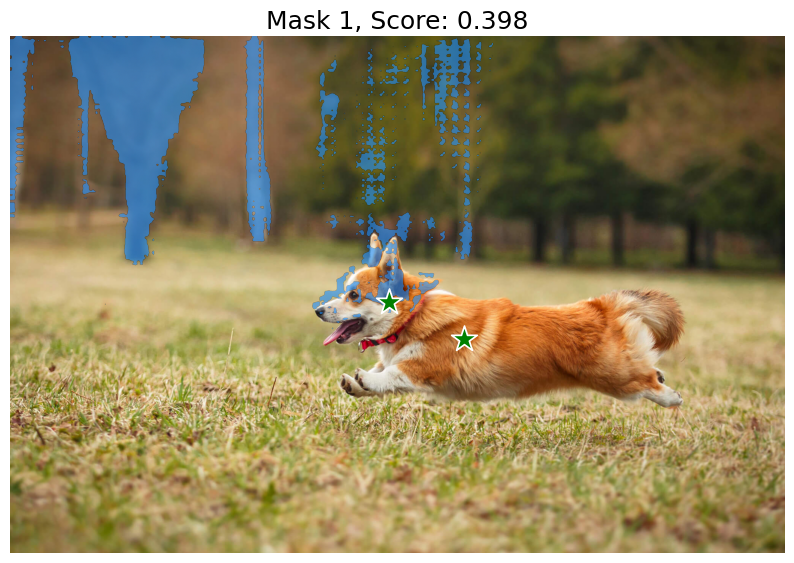

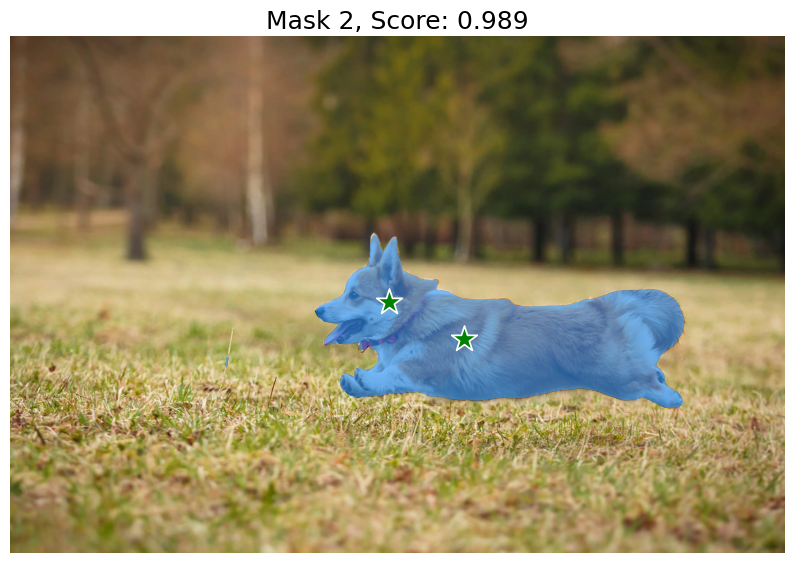

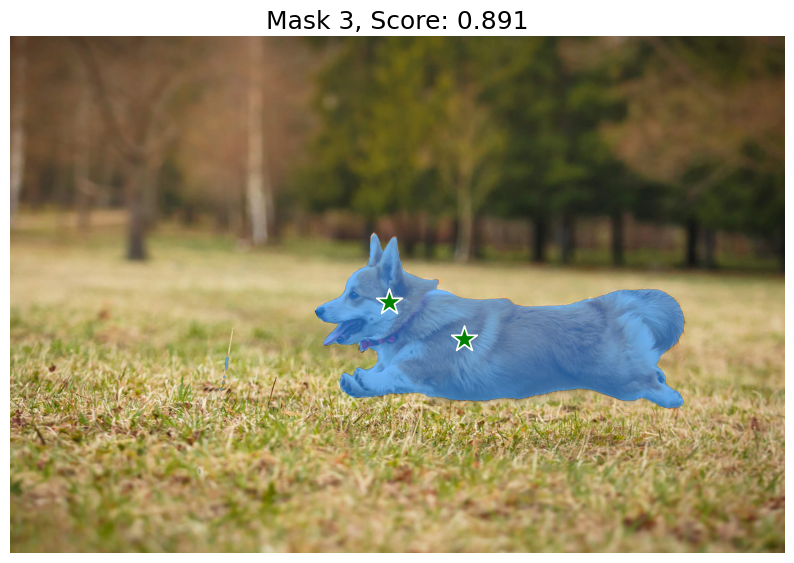

In [13]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [14]:
input_box = np.array([750, 450, 1800, 1000])

masks, _, _ = predictor.predict(box = input_box[None, :])

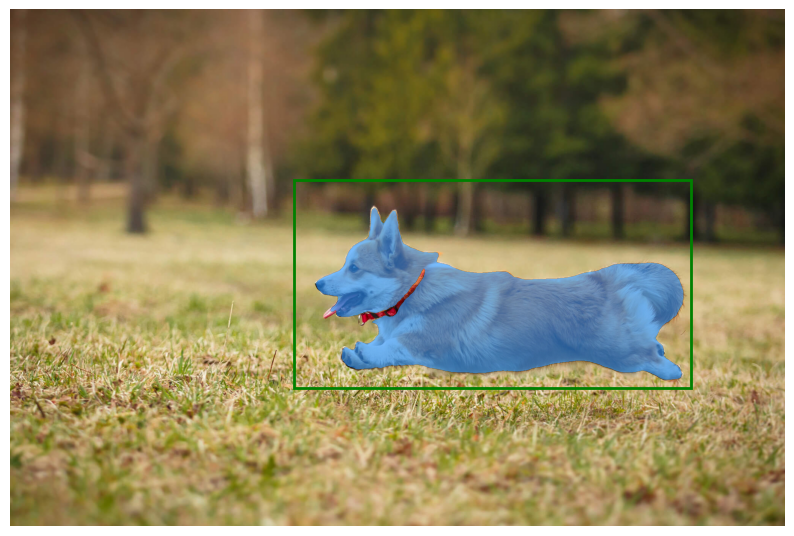

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

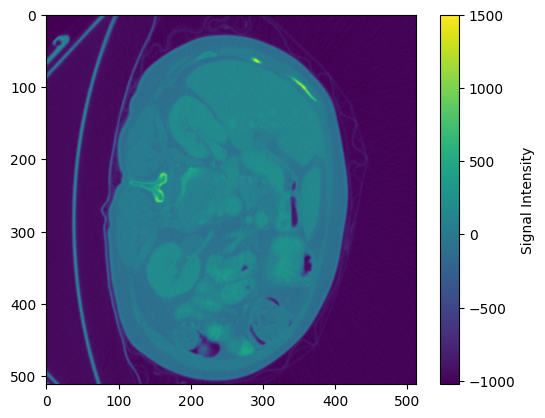

In [16]:
img = nib.load('./data/imagesTr/img0001.nii.gz').get_fdata()

plt.imshow(img[:, :, 100])
plt.colorbar(label='Signal Intensity')

# Test box prompt generation

In [17]:
train_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='training', 
                               preprocess=to_uint8_rgb)
validation_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='validation', 
                               preprocess=to_uint8_rgb)

In [25]:
validation_loader = DataLoader(validation_set, batch_size=4, shuffle=True)

In [26]:
len(validation_loader)

191

In [29]:
batch = next(iter(validation_loader))
boxes = box_prompt(batch['label'])

In [30]:
boxes

[{5: [212, 246, 220, 271], 8: [182, 276, 211, 304]},
 {1: [117, 325, 248, 476],
  6: [142, 34, 390, 339],
  7: [210, 310, 375, 398],
  8: [211, 249, 239, 275],
  9: [221, 188, 254, 229],
  10: [186, 209, 348, 411],
  12: [184, 188, 215, 203],
  13: [193, 305, 205, 314]},
 {9: [235, 213, 259, 240]},
 {}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


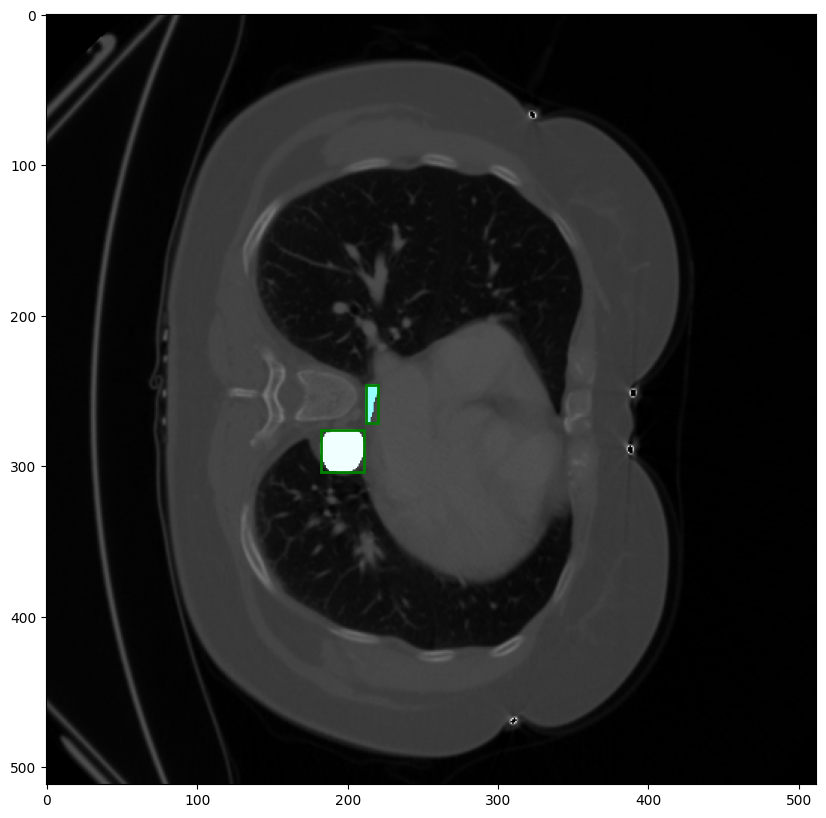

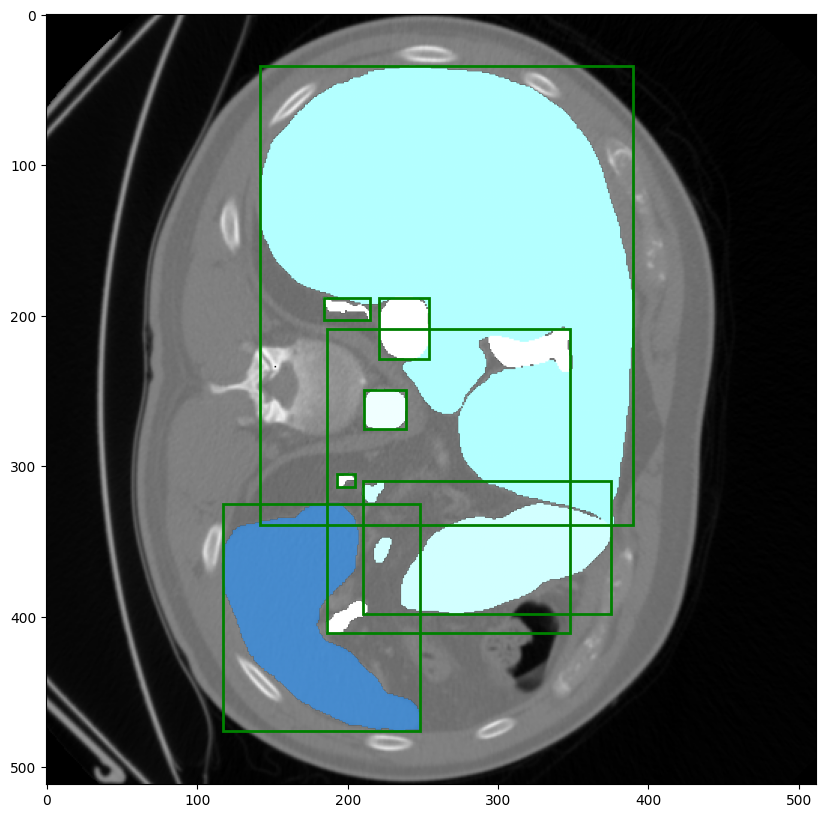

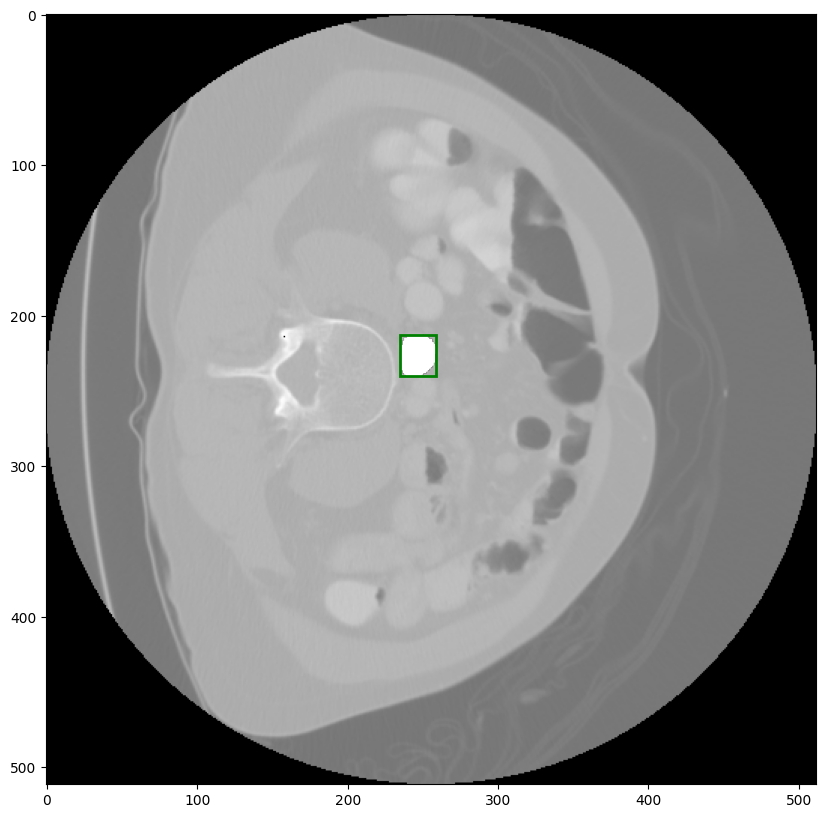

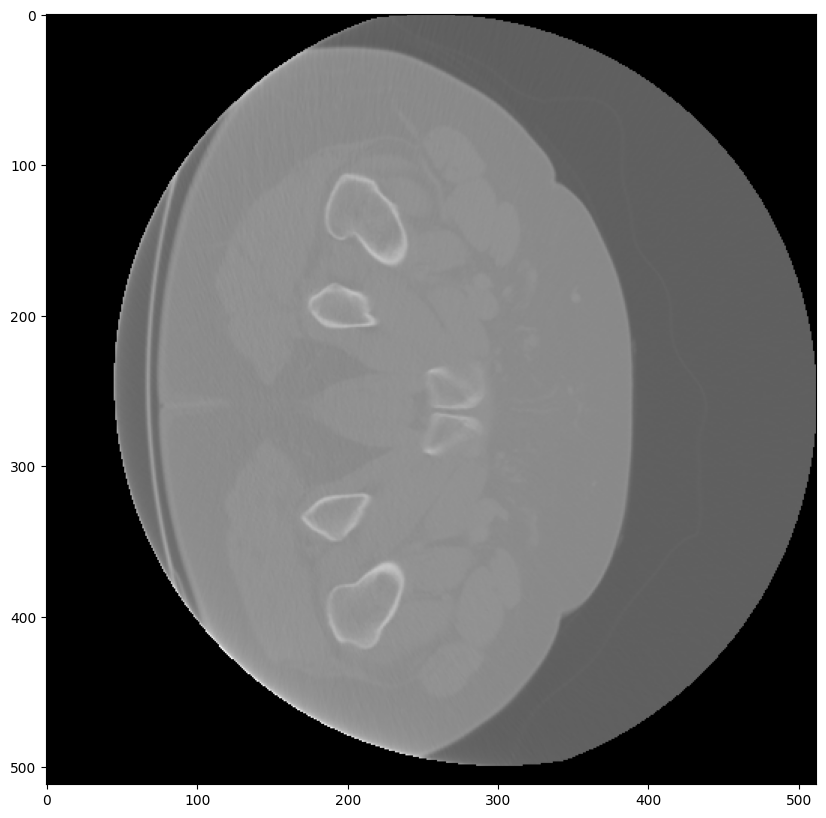

In [31]:
img = batch['image']

for i in range(img.shape[0]):
    plt.figure(figsize=(10,10))
    plt.imshow(img[i])

    show_mask(batch['label'][i], plt.gca())

    bbox = boxes[i]

    for k, b in bbox.items():
        show_box(b, plt.gca())

# Test box input for validation dataset